<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-Подготовка" data-toc-modified-id="1.-Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>1. Подготовка</a></span><ul class="toc-item"><li><span><a href="#Загрузка-и-первичный-анализ" data-toc-modified-id="Загрузка-и-первичный-анализ-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка и первичный анализ</a></span></li><li><span><a href="#Лемматизация" data-toc-modified-id="Лемматизация-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Лемматизация</a></span></li><li><span><a href="#Частотный-анализ-текста" data-toc-modified-id="Частотный-анализ-текста-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Частотный анализ текста</a></span></li><li><span><a href="#Анализ-сбалансированности-классов" data-toc-modified-id="Анализ-сбалансированности-классов-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Анализ сбалансированности классов</a></span></li><li><span><a href="#Подготовка-данных-для-обучения" data-toc-modified-id="Подготовка-данных-для-обучения-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Подготовка данных для обучения</a></span></li></ul></li><li><span><a href="#2.-Обучение" data-toc-modified-id="2.-Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>2. Обучение</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#RidgeClassifier" data-toc-modified-id="RidgeClassifier-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>RidgeClassifier</a></span></li><li><span><a href="#LinearSVC" data-toc-modified-id="LinearSVC-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>LinearSVC</a></span></li><li><span><a href="#Сравнение-моделей" data-toc-modified-id="Сравнение-моделей-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Сравнение моделей</a></span></li><li><span><a href="#Тестирование-лучшей-модели-и-проверка-на-адекватность" data-toc-modified-id="Тестирование-лучшей-модели-и-проверка-на-адекватность-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Тестирование лучшей модели и проверка на адекватность</a></span></li></ul></li><li><span><a href="#3.-Выводы" data-toc-modified-id="3.-Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>3. Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Определение токсичности комментариев

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Требуется обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

Требуется построить модель со значением метрики качества *F1* не меньше 0.75. 

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns 
from PIL import Image

import re

import torch
import transformers

from tqdm import tqdm
from tqdm import notebook
from pandarallel import pandarallel

import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import spacy
from nltk.corpus import stopwords as nltk_stopwords
from nltk.probability import FreqDist

from wordcloud import WordCloud

from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier

from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report

## 1. Подготовка

### Загрузка и первичный анализ

In [11]:
# читаем csv-файл и сохраняем в переменную df
try:
    df = pd.read_csv('/Users/sergeypervov/Downloads/toxic_comments.csv', index_col=0)
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv', index_col=0) 

df.head() # смотрим случайные 5 строк из датасета для ознакомления 

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [12]:
df.sample(5)

,text,toxic
79759,"""\n\n Please do not vandalize pages, as you di...",0
36564,"""\n\nMe too. To quote from the article:\n\nGo...",0
63558,Comment \n\nHey there. Thanks for defending me...,0
95002,Have reported your actions per WP:STALK.,0
21212,didn't sign this so u cant ban me as u don't k...,1


In [13]:
df.index.is_monotonic

True

**Вывод:** Индексы идут последовательно и без пропусков. Также видим наличие в строках столбца 'text' заглавные буквы, полезной информации они не несут, так что сразу приведем значения к строчным буквам.	

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


**Вывод:** В датасете 159292 строки, пропусков нет, форматы адекватные.

In [15]:
df['text'] = df['text'].str.lower()
#df = df.drop(['Unnamed: 0'], axis=1)
df.head()

,text,toxic
0,explanation\nwhy the edits made under my usern...,0
1,d'aww! he matches this background colour i'm s...,0
2,"hey man, i'm really not trying to edit war. it...",0
3,"""\nmore\ni can't make any real suggestions on ...",0
4,"you, sir, are my hero. any chance you remember...",0


**Вывод:** Оставили только строчные символы <strike>и убрали лишний столбец<strike>. 
    
Теперь очистим текст от всего кроме строчных букв английского алфавита (заглавные мы уже привели к строчным ранее) и лемматизируем его.

### Лемматизация

In [16]:
corpus = df['text'] #.astype('U') # переведём тексты в стандартный для Python формат: кодировку Unicode

In [17]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sergeypervov/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [18]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sergeypervov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [19]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sergeypervov/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

### Wordnet lemm

In [258]:
# пишем функцию для добавления POS-тегов
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [259]:
def lemmatize(text):
    lemmatizer = WordNetLemmatizer() # язык английский, так что используем WordNet
    clrd_text = ' '.join(re.sub(r'[^a-z]', ' ', text).split())
    lemm_text = ' '.join(lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(clrd_text)) 
    return lemm_text          #' '.join(clrd_text.split())

### SpaCy

In [20]:
nlp = spacy.load('en_core_web_sm')

In [21]:
def lemma_clear(text):
    lemm = nlp(text)
    lemm = ' '.join([token.lemma_ for token in lemm])


    return ' '.join(lemm.split())

In [22]:
tqdm.pandas(desc="progress") 
pandarallel.initialize(progress_bar = True)

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [261]:
df['lemm_text'] = corpus.parallel_apply(lemmatize)
df.sample(5)

,text,toxic,lemm_text
68514,"""\n\n changing references tags to reflist. \n\...",0,change reference tag to reflist don t know if ...
126153,election/party info template \n\ni think the s...,0,election party info template i think the set u...
94386,"""\n\nspeedy deletion of unholy force\n a tag h...",0,speedy deletion of unholy force a tag have be ...
123985,adming is the one who abuses wikipedia to for...,1,adming be the one who abuse wikipedia to force...
34297,this uneducated user:tajik even goes to pashtu...,0,this uneducated user tajik even go to pashtun ...


In [23]:
df['spacy_text'] = corpus.parallel_apply(lemma_clear)
df.sample(5)

,text,toxic,spacy_text
127065,"""welcome\n\nhello, and welcome to wikipedia! t...",0,""" welcome hello , and welcome to wikipedia ! t..."
76809,congrats \n\ncongratulations on being a publis...,0,congrat congratulation on be a publish book au...
154511,"but other call him: partyjniak 22:41, 9 feb 2...",0,"but other call he : partyjniak 22:41 , 9 feb 2..."
44461,jozef tiso lead \n\nsince i have not received ...,0,jozef tiso lead since I have not receive a res...
14463,hasmens\ndr.k i think your ridiculous remarks ...,0,hasmen dr.k I think your ridiculous remark to ...


Лемматизированные тексты добавили в датасет, можно будет уже их использовать, как основу для фичей (векторов). Так как перед нами задача классификации, еще необходимо проанализировать баланс классов, чтобы учесть этот фактор при обучении.

### Частотный анализ текста

In [262]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))    
#stopwords.extend(['u', ...])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sergeypervov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [263]:
toxic = df[df['toxic'] == 1]
positive = df[df['toxic'] == 0]

In [264]:
corpus_toxic = ' '.join(toxic['lemm_text'])
corpus_positive = ' '.join(positive['lemm_text'])

In [302]:
# генерируем облако слов
wordcloud_toxic = WordCloud(stopwords=stopwords, collocations=False).generate(corpus_toxic)  


wordcloud_positive = WordCloud(stopwords=stopwords, background_color='white', collocations=False) \
.generate(corpus_positive)

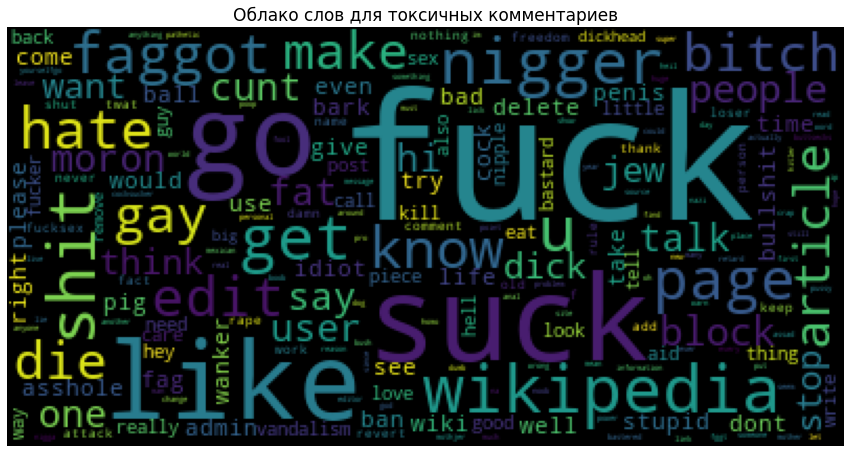

In [303]:
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud_toxic)  #interpolation='bilinear'
plt.title('Облако слов для токсичных комментариев', fontsize=17)
plt.axis('off');

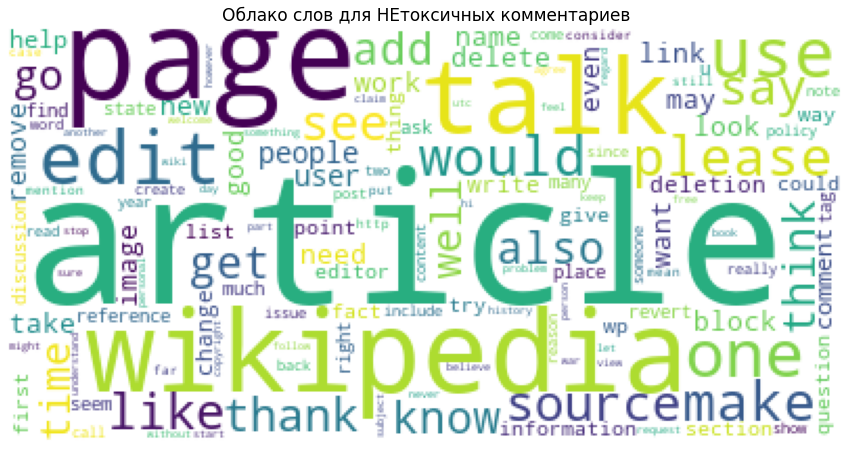

In [304]:
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud_positive)  #interpolation='bilinear'
plt.title('Облако слов для НЕтоксичных комментариев', fontsize=17)
plt.axis('off');

In [268]:
toxic_tokens = word_tokenize(corpus_toxic)
filtered_toxic = [word for word in toxic_tokens if word not in stopwords]
toxic_text = nltk.Text(filtered_toxic)

fdist_toxic = FreqDist(toxic_text)

print(f'Частотность ТОП-10 слов из токсичных комментариев: {fdist_toxic.most_common(10)}')

Частотность ТОП-10 слов из токсичных комментариев: [('fuck', 13527), ('suck', 4820), ('go', 4321), ('like', 3949), ('wikipedia', 3927), ('shit', 3721), ('u', 3493), ('nigger', 3434), ('get', 3379), ('page', 2858)]


In [269]:
positive_tokens = word_tokenize(corpus_positive)
filtered_positive = [word for word in positive_tokens if word not in stopwords]
positive_text = nltk.Text(filtered_positive)

fdist_positive = FreqDist(positive_text)

print(f'Частотность ТОП-10 слов из НЕтоксичных комментариев: {fdist_positive.most_common(10)}')

Частотность ТОП-10 слов из НЕтоксичных комментариев: [('article', 72275), ('page', 54253), ('wikipedia', 44545), ('talk', 38527), ('use', 30913), ('edit', 29070), ('one', 28881), ('please', 28734), ('make', 28216), ('would', 28102)]


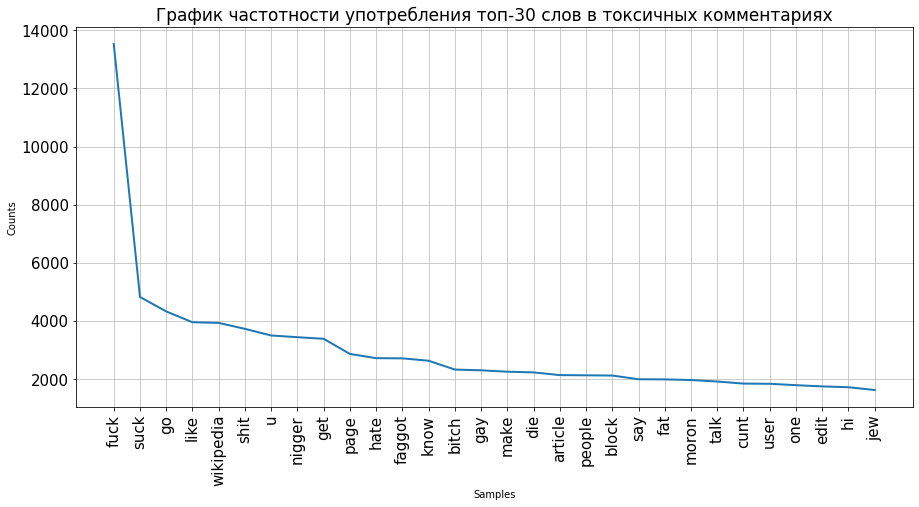

In [270]:
plt.figure(figsize=(15, 7))
plt.title('График частотности употребления топ-30 слов в токсичных комментариях', fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
fdist_toxic.plot(30, cumulative=False);

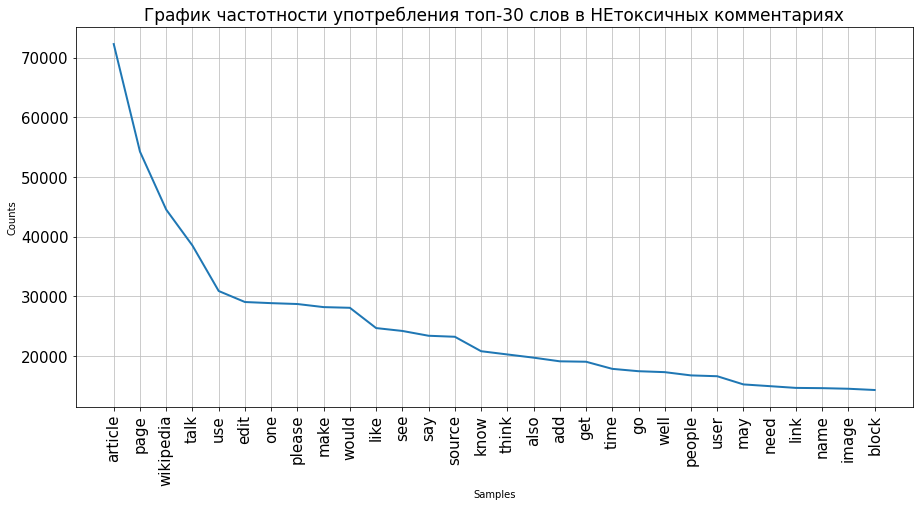

In [271]:
plt.figure(figsize=(15, 7))
plt.title('График частотности употребления топ-30 слов в НЕтоксичных комментариях', fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
fdist_positive.plot(30, cumulative=False);

**Вывод:** Интересный момент - слово "википедия" в топ-5 упоминаний как в токсичных, так и в нетоксичных комментариях, в остальном же в токсичных комментариях преобладают ругательства.

### Анализ сбалансированности классов

In [272]:
df['toxic'].value_counts() #баланс классов в количественном соотношении

0    143106
1     16186
Name: toxic, dtype: int64

In [273]:
df['toxic'].value_counts(normalize=True) #баланс классов в долевом соотношении

0    0.898388
1    0.101612
Name: toxic, dtype: float64

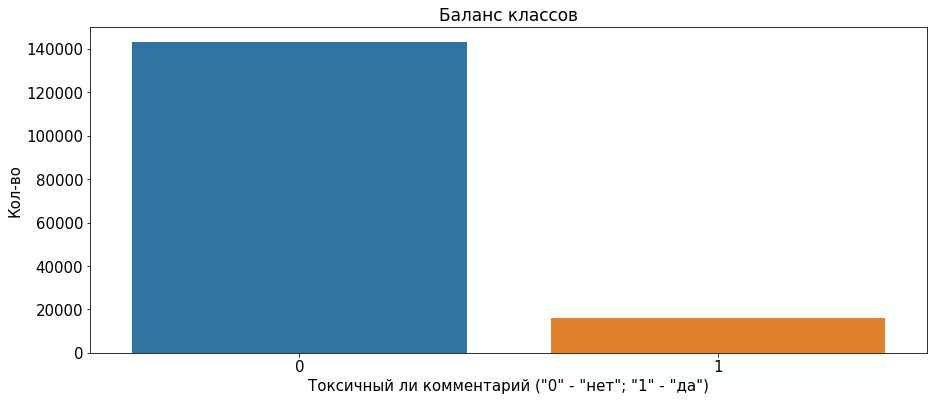

In [274]:
plt.figure(figsize=(15, 6))
ax = sns.countplot(x='toxic', data=df)
ax.set_title('Баланс классов', fontsize=17)
ax.set_xlabel('Токсичный ли комментарий ("0" - "нет"; "1" - "да")',fontsize=15)
ax.set_ylabel('Кол-во',fontsize=15)
ax.tick_params(labelsize=15);

**Вывод:** Соотношение классов '0' к '1' - примерно 9:1, учтем дисбаланс при делении на выборки и обучении.

### Подготовка данных для обучения

In [60]:
RS = 12345
TS = 0.2
text_features = ['text']

### CatBoost Baseline

In [58]:
features_cbc = df.drop(['toxic', 'spacy_text'], axis=1)
target_cbc = df['toxic']

In [61]:
features_train_valid_cbc, features_test_cbc, target_train_valid_cbc, target_test_cbc = train_test_split(
    features_cbc, target_cbc, test_size=0.2, random_state=RS) # отделяем 20% данных для тестовой выборки
features_train_cbc, features_valid_cbc, target_train_cbc, target_valid_cbc = train_test_split(
    features_train_valid_cbc, target_train_valid_cbc, test_size=0.25, random_state=RS)

In [64]:
cw = [1,(df['toxic']==0).sum() / (df['toxic']==1).sum()]
cw

[1, 8.841344371679229]

In [86]:
cbc = CatBoostClassifier(verbose=100,
                           learning_rate=0.7,
                           early_stopping_rounds=200,
                           eval_metric='AUC',
                           auto_class_weights='Balanced'
                           )

In [87]:
cbc.fit(features_train_cbc, target_train_cbc, eval_set=(features_valid_cbc, target_valid_cbc), text_features \
        =text_features)

0:	test: 0.8440004	best: 0.8440004 (0)	total: 179ms	remaining: 2m 59s
100:	test: 0.9381944	best: 0.9420167 (21)	total: 20.5s	remaining: 3m 2s
200:	test: 0.9370813	best: 0.9420167 (21)	total: 40.8s	remaining: 2m 42s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.942016739
bestIteration = 21

Shrink model to first 22 iterations.


In [88]:
print(classification_report(target_test_cbc, cbc.predict(features_test_cbc)))

              precision    recall  f1-score   support

           0       0.98      0.91      0.95     28629
           1       0.52      0.84      0.65      3230

    accuracy                           0.91     31859
   macro avg       0.75      0.88      0.80     31859
weighted avg       0.93      0.91      0.92     31859



In [89]:
pred_test_cbc = cbc.predict(features_test_cbc)

In [90]:
round(f1_score(target_test_cbc, pred_test_cbc), 4)

0.6457

### TOXIC BERT

In [93]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TextClassificationPipeline

In [94]:
model_path = 'martin-ha/toxic-comment-model'

In [95]:
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

pipeline =  TextClassificationPipeline(model=model, tokenizer=tokenizer)

Downloading:   0%|          | 0.00/403 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/704 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

In [96]:
test_bert = df.sample(1000, weights='toxic', random_state=123)

In [97]:
y_pred = []
for text in tqdm(test_bert['text']):
    # print(text)
    pred = pipeline(text[:512])
    y_pred.append(1 if pred[0]['label'] == 'toxic' else 0)

100%|███████████████████████████████████████| 1000/1000 [02:55<00:00,  5.70it/s]


In [98]:
y_pred

[0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,


In [99]:
round(f1_score(test_bert['toxic'], y_pred), 4)

0.7421

**Вывод:** Размерность фичей в тренировочной и тестовой выборках совпадают, значит трансформация прошла корректно, можно переходить к обучению моделей. 

## 2. Обучение

### LogisticRegression

In [279]:
lr_params={'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)],
           'lr__class_weight': ['balanced', None],
           'lr__solver': ['saga', 'liblinear'] }
lr_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords)),
    ('lr', LogisticRegression(random_state=RS))])
lr_cv = GridSearchCV(lr_pipeline, cv=5, n_jobs=-1, param_grid=lr_params, scoring='f1')
lr_cv_df = lr_cv.fit(features_train, target_train)
#lr_cv.score(features_train, target_train)

/Users/sergeypervov/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sergeypervov/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sergeypervov/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sergeypervov/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sergeypervov/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sergeype

In [280]:
print(f'Значения лучших гиперпараметров для модели LogisticRegression: {lr_cv_df.best_params_}')
print(f'Значение лучшего f1 линейной модели при кросс-валидации: {round(lr_cv_df.best_score_, 4)}')

Значения лучших гиперпараметров для модели LogisticRegression: {'lr__class_weight': 'balanced', 'lr__solver': 'liblinear', 'tfidf__ngram_range': (1, 2)}
Значение лучшего f1 линейной модели при кросс-валидации: 0.7444


### RidgeClassifier

In [281]:
rc_params={'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)],
           'rc__class_weight': ['balanced', None],
           'rc__solver': ['auto', 'lsqr', 'sparse_cg'] }
rc_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords)),
    ('rc', RidgeClassifier(random_state=RS))])
rc_cv = GridSearchCV(rc_pipeline, cv=5, n_jobs=-1, param_grid=rc_params, scoring='f1')
rc_cv_df = rc_cv.fit(features_train, target_train)

In [282]:
print(f'Значения лучших гиперпараметров для модели RidgeClassifier: {rc_cv_df.best_params_}')
print(f'Значение лучшего f1 линейной модели при кросс-валидации: {round(rc_cv_df.best_score_, 4)}')

Значения лучших гиперпараметров для модели RidgeClassifier: {'rc__class_weight': 'balanced', 'rc__solver': 'lsqr', 'tfidf__ngram_range': (1, 2)}
Значение лучшего f1 линейной модели при кросс-валидации: 0.7557


### LinearSVC

In [284]:
svc_params={'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)],
            'svc__C': np.arange(0.2, 1.1, 0.2),
            'svc__class_weight': ['balanced', None] }
svc_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords)),
    ('svc', LinearSVC(random_state=RS))])
svc_cv = GridSearchCV(svc_pipeline, cv=5, n_jobs=-1, param_grid=svc_params, scoring='f1')
svc_cv_df = svc_cv.fit(features_train, target_train)

In [285]:
print(f'Значения лучших гиперпараметров для модели LinearSVC: {svc_cv_df.best_params_}')
print(f'Значение лучшего f1 линейной модели при кросс-валидации: {round(svc_cv_df.best_score_, 4)}')

Значения лучших гиперпараметров для модели LinearSVC: {'svc__C': 1.0, 'svc__class_weight': 'balanced', 'tfidf__ngram_range': (1, 2)}
Значение лучшего f1 линейной модели при кросс-валидации: 0.7859


### Сравнение моделей

In [286]:
models_cv_comparison = pd.DataFrame()
models_cv_comparison['model'] = ['LogisticRegression', 'RidgeClassifier', 'LinearSVC']
models_cv_comparison['f1'] = [lr_cv_df.best_score_, rc_cv_df.best_score_, svc_cv_df.best_score_]
models_cv_comparison

,model,f1
0,LogisticRegression,0.744449
1,RidgeClassifier,0.755750
2,LinearSVC,0.785927


**Вывод:** Лучше всего на кросс-валидации на тренировочной выборке показала себя модель LinearSVC (f1 = 0.79). Проверим ее на тестовой выборке и сравним с константной моделью.

### Тестирование лучшей модели и проверка на адекватность

In [288]:
pred_test_svc = svc_cv.best_estimator_.predict(features_test)

print(f'Значение f1 модели LinearSVC с лучшими гиперпараметрами на тестовой выборке: \
      {round(f1_score(target_test, pred_test_svc), 2)}')
print(f'Значение accuracy модели LinearSVC с лучшими гиперпараметрами на тестовой выборке: \
      {round(accuracy_score(target_test, pred_test_svc), 2)}')

Значение f1 модели LinearSVC с лучшими гиперпараметрами на тестовой выборке:       0.79
Значение accuracy модели LinearSVC с лучшими гиперпараметрами на тестовой выборке:       0.96


In [289]:
dc = DummyClassifier(strategy = 'constant', constant = 1) # класс 0 встречается чаще, но если мы выберем стратегию, 
# где будут только 0, то f1 будет равен 0 
dc.fit(features_train, target_train)
pred_test_dc = dc.predict(features_test)
print(f1_score(target_test, pred_test_dc))

0.18446546614998857


In [291]:
dc = DummyClassifier(strategy = 'constant', constant = 0) # а вот для accuracy можем взять константную модель 
# которая предсказывает одни 0, а это минимум 80% значений, так что показатель должен быть достаточно высокий
dc.fit(features_train, target_train)
pred_test_dc = dc.predict(features_test)
print(accuracy_score(target_test, pred_test_dc))

0.8983960576289275


**Вывод:** Модель LinearSVC на тестовой выборке показала даже немного лучший результат по f1, чем на тренировочной (0.79). А несмотря на высокий результат метрики accuracy у константной модели, выдающей только 0 (0.9), accuracy LinearSVC ощутимо выше (0.96), что говорит об адекватности модели.

## 3. Выводы

Модель LinearSVC на тестовой выборке показала даже немного лучший результат, чем на тренировочной (0.78), но, главное, что он выше порога (0.75), а, значит, цель достигнута. Учитывая объем датасета и время, которое бы потребовалось на предобработку фичей моделью BERT, очень неплохо, что требуемы результат удалось достигнуть менее ресурсозатратным применением векторизатора TF-IDF с применением относительно простых моделей для скассификации. Любопытно, что если линейные модели показывали лушие результаты на обучении при учете дисбаланса классов в настройках, то лучшая модель LinearSVC показала лучшую метрику как раз без учета дисбаланса классов. 